# Topic Modeling
### Bert Sentence Embedding, LDA, and K-means Clustering

#### Concatenate the sentence embeddings with LDA, use an autoencoder to get the latent representation and perform K-means to perform clustering on the data

#### After the sentences have been assigned to their clusters, we can extract the candidate topics for each cluster using tokens of it's sentences

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
% cd /content/drive/My Drive/Thesis_colab

In [ ]:
! pip install transformers
! pip install pandas
! pip install torch
! pip install nltk
! pip install gensim
! pip install matplotlib
! pip install umap-learn
! pip install wordcloud
! pip install sklearn
! pip install tqdm
! pip install stop_words
! pip install xlrd
! pip install langdetect
! pip install openpyxl
! pip install sentence_transformers
! pip install pyLDAvis
! pip install pickle5


In [ ]:
# install ocra to save figures using plotly
!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get update
!apt-get install xvfb libgtk2.0-0 libgconf-2-4


In [2]:
import nltk
import numpy as np
import statistics
from sklearn.decomposition import PCA
from collections import Counter
import pandas as pd

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

### 1. Reading and preprocessing the data

In [3]:
from utilities.document_preprocessing import preprocess_documents

#### The preprocess_document function reads the sentences from the file and generates tokens from each sentences.

In [4]:
Verbose = False

In [5]:
# Read new data file
file = "data/PMP_Skills_Matching_Pilot_2018_2019.xlsx"
#file = "/home/anum/Downloads/25828_32915_compressed_Train_rev1.csv/Train_rev1.csv"
#file = "data/job_small.xlsx"
#file = "data/Train_rev1.csv"

ids, sentences, token_lists , sentences_titles = preprocess_documents(file, verbose = Verbose, 
                                                   dr = "output/preprocessed_data/",
                                                 max_sent_length= 1001)


ids = list (ids)
num_docs = len(ids)


Reading the file
Shortest Objective is of length  0
Largest Objective is of length  1214
Preprocessing raw texts 

0
Couldn't detect the language of the text on index 156
Couldn't detect the language of the text on index 311
Dropped 27 entries with non english text

 Preprocessing raw texts. Done!


In [ ]:
#read the previously processed data

data_file = "data/flask/use_this_data.pkl"
#data_file = "output/11.09.2020/mercks_objectives/use_this_data_merck_unique.pkl"
data_file = "output/02.10.2020/use_this_data_50000_job.pkl"
data_file = "output/preprocessed_data/job/10000/use_this_data.pkl"

import pickle5 as pickle

with (open(data_file, "rb")) as openfile:
    data = pickle.load(openfile)
sentences = data['sentences']
token_lists = data['token_list']
ids = data['id']


In [6]:
len(ids)

484

## 2. Topic Modeling

In [7]:
from models.topic_model import Topic_Model

[nltk_data] Downloading package wordnet to /home/anum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### The topic_Model class does the follow
- Extract sentence embeddings for all sentences (Local features)
- get topic distribution for each sentence using LDA/LSI
- concatenate both and learn the latent representation using an auto-encoder
- cluster the latent representation into K clusters

##### Available embeddings: ['xlnet', 'electra', 'xlm', 'bert','albert', 'bert-sent','roberta-sent', 'distilbert-sent']
where '-sent' corresponds to the sentence transformer library and all the other models belong to hugging face library.

Attention vectors would only be available with the models from hugging face

In [8]:
# define the number of clusters
k = 5

In [9]:
# Define the topic model object
TopicModelObject = Topic_Model(base = None, k = k, verbose = False, embedding = 'bert-sent',
                               saved_embedding_dir = None, output_attention = False,
                               embedding_batch_size = 200, use_AE= False)

In [ ]:
# for Colab
# Define the topic model object
TopicModelObject = Topic_Model( base = None, k = k, verbose = False, embedding = 'bert', gamma = 15,
                               saved_embedding_dir = None, embedding_batch_size = 100, use_AE= False,
                               output_attention = True)

In [10]:
# Fit the topic model
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)


    TopicModelObject.fit(sentences, token_lists, epoch = 5, vis_clusters = False)


 Getting vector representations for bert-sent 
cpu
Embedding for batch 0 out of 2 batches Completed.
Embedding for batch 1 out of 2 batches Completed.
Our final sentence embedding vector of shape: 484 768
Clustering. Done!
Silhouette Score for the clusters is 0.05861809497941807


In [11]:
TopicModelObject.vec

{'EMBEDDING': array([[ 0.06518789,  0.42039588,  1.41698277, ..., -0.39610529,
         -0.39725825,  0.01439655],
        [-0.86313933,  0.61444837,  0.79524696, ..., -0.35794955,
          0.17833138,  0.20265585],
        [-0.56924421,  0.6948126 ,  2.01016068, ..., -0.07689679,
         -0.00900018,  0.13298596],
        ...,
        [-0.61355519,  0.83258772,  0.79403329, ..., -0.59560037,
          0.13081864, -0.15711042],
        [-0.31851304,  1.11338592,  1.34936333, ..., -0.01021551,
         -0.43040642,  0.05809831],
        [-0.66821241,  1.10915077,  0.81088352, ..., -0.78560615,
         -0.81399906,  0.27934489]]),
 'attention': None,
 'embedding_tokens': []}

## 3. Analysis on learned features

#### Preprocessing (Dimensionality Reduction) for visualization

Perform Dimensionality reduction on the learned features 


In [32]:
# Getting feature vectors and cluster labels assigned by the model
if TopicModelObject.method == 'LDA' or TopicModelObject.method =='LSI':
    feature_vector = TopicModelObject.vec[TopicModelObject.method]
    # for each sentence, find out the cluster it belongs to
    cluster_label_per_document = np.argmax(np.array(feature_vector), axis=1)
else:
    cluster_label_per_document = np.array(TopicModelObject.cluster_model.labels_)
    feature_vector = TopicModelObject.vec[TopicModelObject.method]
    

unique_ids = list(set(ids))
num_employee = len(unique_ids)

In [33]:
# Create place holder for the analysis
averaged_employee_features = pd.DataFrame(None, index=pd.Index(unique_ids, name='Employee id'),
                                          columns=pd.Index(
                                              ['feature_vector', 'cluster', 'feature_vector_2d', 'feature_vector_3d'],
                                              name='Compressed_features'))
averaged_employee_features

Compressed_features feature_vector cluster feature_vector_2d feature_vector_3d
Employee id                                                                   
*100127                        NaN     NaN               NaN               NaN
*100099                        NaN     NaN               NaN               NaN
*100443                        NaN     NaN               NaN               NaN
*100227                        NaN     NaN               NaN               NaN
*100005                        NaN     NaN               NaN               NaN
...                            ...     ...               ...               ...
*100075                        NaN     NaN               NaN               NaN
*100103                        NaN     NaN               NaN               NaN
*100033                        NaN     NaN               NaN               NaN
*100151                        NaN     NaN               NaN               NaN
*100201                        NaN     NaN               NaN               NaN

[484 rows x 4 columns]

In [34]:
# get the indices of all objectives/documents/sentence for each employee (for later use)
employee_objective_indices = dict()
for employee in ids:
    employee_indices = [i for i, e in enumerate(ids) if (ids[i] == employee) ]
    employee_objective_indices[employee] = employee_indices[0]
employee_objective_indices

{'*100127': 116,
 '*100099': 91,
 '*100443': 418,
 '*100227': 210,
 '*100005': 5,
 '*100464': 439,
 '*100215': 199,
 '*100112': 103,
 '*100358': 338,
 '*100506': 478,
 '*100346': 326,
 '*100082': 75,
 '*100052': 48,
 '*100235': 218,
 '*100273': 256,
 '*100478': 453,
 '*100240': 223,
 '*100019': 18,
 '*100431': 406,
 '*100340': 320,
 '*100041': 37,
 '*100153': 142,
 '*100044': 40,
 '*100334': 314,
 '*100444': 419,
 '*100223': 206,
 '*100155': 144,
 '*100020': 19,
 '*100332': 312,
 '*100116': 107,
 '*100002': 2,
 '*100205': 190,
 '*100364': 344,
 '*100304': 285,
 '*100184': 171,
 '*100272': 255,
 '*100490': 465,
 '*100040': 36,
 '*100500': 473,
 '*100243': 226,
 '*100173': 160,
 '*100449': 424,
 '*100183': 170,
 '*100422': 397,
 '*100063': 58,
 '*100315': 295,
 '*100148': 137,
 '*100283': 265,
 '*100325': 305,
 '*100371': 350,
 '*100372': 351,
 '*100296': 277,
 '*100091': 84,
 '*100211': 195,
 '*100196': 182,
 '*100392': 370,
 '*100324': 304,
 '*100233': 216,
 '*100388': 366,
 '*100206':

In [35]:
#  putting values in the place holder

for employee in ids:
    #get the feature vectors belonging to an employee
    averaged_employee_features['feature_vector'][employee] = feature_vector[employee_objective_indices[employee]]
    
    
    # assign the predicted label for that employe
    averaged_employee_features['cluster'][employee] = cluster_label_per_document[employee_objective_indices[employee]] 
    
averaged_employee_features

Compressed_features                                     feature_vector  \
Employee id                                                              
*100127              [-0.5453292727470398, 0.6274833083152771, 0.54...   
*100099              [-0.1590719223022461, 1.0328922271728516, 1.70...   
*100443              [-0.9139522314071655, 0.8758607506752014, 0.96...   
*100227              [-0.38544031977653503, 0.6343091726303101, 1.5...   
*100005              [-0.873820960521698, 0.5561266541481018, 1.236...   
...                                                                ...   
*100075              [-0.3503970503807068, 0.8993262052536011, 1.11...   
*100103              [-0.5971986651420593, 1.0134649276733398, 1.34...   
*100033              [-0.23445186018943787, 1.1702725887298584, 1.0...   
*100151              [-0.35218921303749084, 0.7494181990623474, 1.2...   
*100201              [-0.7942383885383606, 1.0637187957763672, 1.06...   

Compressed_features cluster feature_vector_2d feature_vector_3d  
Employee id                                                      
*100127                   2               NaN               NaN  
*100099                   1               NaN               NaN  
*100443                   2               NaN               NaN  
*100227                   2               NaN               NaN  
*100005                   2               NaN               NaN  
...                     ...               ...               ...  
*100075                   0               NaN               NaN  
*100103                   2               NaN               NaN  
*100033                   1               NaN               NaN  
*100151                   1               NaN               NaN  
*100201                   2               NaN               NaN  

[484 rows x 4 columns]

In [36]:
# 3) doing dimensionality reduction into 2d/3d Space
from sklearn.manifold import TSNE

#todo: find a more permanent solution for this
# panda returns a array of array for the column feature vector. Converting from array of array to 2d array
feature_vector_ = np.stack(averaged_employee_features['feature_vector'].to_numpy())

# reduce dimension of feature vectors into 2
feature_vector_2d = TSNE(n_components=2).fit_transform(feature_vector_)
averaged_employee_features['feature_vector_2d'] = list(feature_vector_2d)

# reduce dimension of feature vectors into 3
feature_vector_3d = TSNE(n_components=3).fit_transform(feature_vector_)
averaged_employee_features['feature_vector_3d'] = list(feature_vector_3d)


averaged_employee_features

Compressed_features                                     feature_vector  \
Employee id                                                              
*100127              [-0.5453292727470398, 0.6274833083152771, 0.54...   
*100099              [-0.1590719223022461, 1.0328922271728516, 1.70...   
*100443              [-0.9139522314071655, 0.8758607506752014, 0.96...   
*100227              [-0.38544031977653503, 0.6343091726303101, 1.5...   
*100005              [-0.873820960521698, 0.5561266541481018, 1.236...   
...                                                                ...   
*100075              [-0.3503970503807068, 0.8993262052536011, 1.11...   
*100103              [-0.5971986651420593, 1.0134649276733398, 1.34...   
*100033              [-0.23445186018943787, 1.1702725887298584, 1.0...   
*100151              [-0.35218921303749084, 0.7494181990623474, 1.2...   
*100201              [-0.7942383885383606, 1.0637187957763672, 1.06...   

Compressed_features cluster         feature_vector_2d  \
Employee id                                             
*100127                   2      [-8.552294, 7.88901]   
*100099                   1      [1.7834, 0.36586943]   
*100443                   2   [-8.849701, -1.2160542]   
*100227                   2     [7.012937, 11.691957]   
*100005                   2   [-10.128673, 15.921746]   
...                     ...                       ...   
*100075                   0    [7.2083683, -18.76859]   
*100103                   2  [-16.959427, -6.8473544]   
*100033                   1    [10.460888, 17.044563]   
*100151                   1     [8.766644, 6.8025675]   
*100201                   2   [-8.154128, -13.514026]   

Compressed_features                    feature_vector_3d  
Employee id                                               
*100127                  [25.248972, 34.47901, 99.92194]  
*100099                 [3.2061384, 107.3847, 16.828234]  
*100443                 [23.13572, -75.26141, 118.35768]  
*100227               [16.296923, -51.47497, -3.6072168]  
*100005                [49.641598, 6.454818, -46.753674]  
...                                                  ...  
*100075                  [56.08177, 68.75703, -99.94044]  
*100103                 [36.93305, -24.36024, 59.640125]  
*100033              [-29.527628, 44.509663, -120.99188]  
*100151               [-29.299461, 78.97914, -40.935352]  
*100201                [-24.15334, 19.289774, 118.00461]  

[484 rows x 4 columns]

## 4.1 Visualization: Word Cloud

In [17]:
from utilities.visualizations import get_wordcloud
from utilities.utils import generate_n_gram, clean_topics_from_clusters, get_main_topics
%matplotlib inline

In [18]:
#Getting indexes of sentences belonging to each cluster
sentence_label_dict = dict()

if TopicModelObject.method == 'LDA':
    labels = np.argmax(TopicModelObject.vec['LDA'], axis=1)
else:
    labels = TopicModelObject.cluster_model.labels_

for label in set(labels):
    sentence_label_dict[label] = [idx for idx, l in enumerate(labels) if l == label]

#### 4.1.1 Wordcloud using top words from frequency of words 

WordClouds for 1 grams
Coherence Score before cleaning of redundant words
0.37524252691745896
Coherence Score after cleaning of redundant words
0.40071057429712614
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!
WordClouds for 2 grams
Coherence Score before cleaning of redundant words
0.7980485813388091
Coherence Score after cleaning of redundant words
0.7534369416743859
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
G

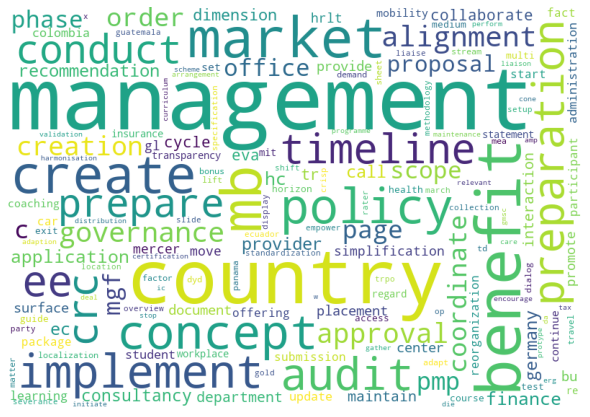

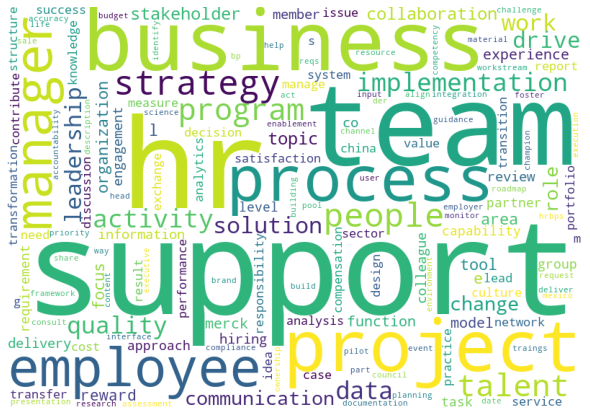

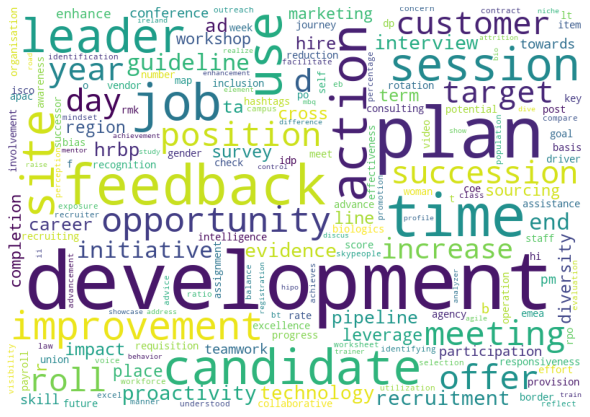

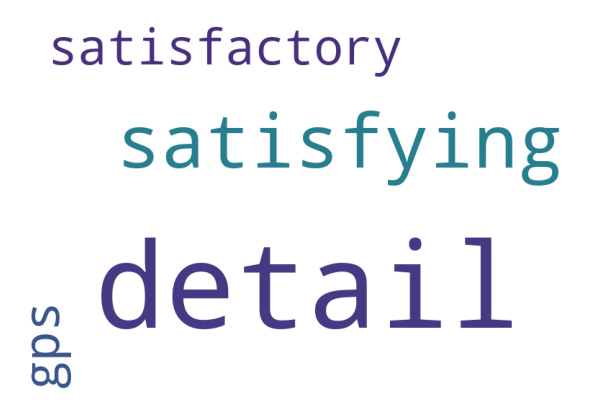

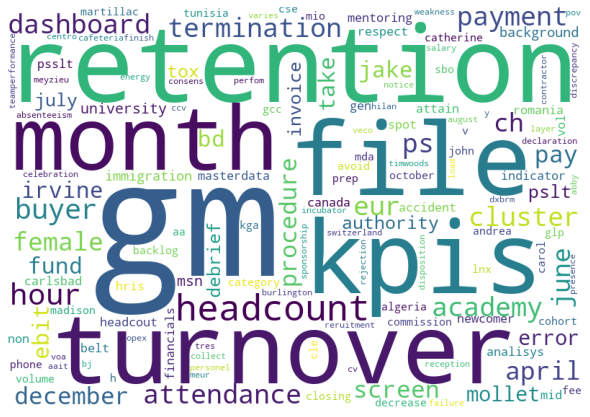

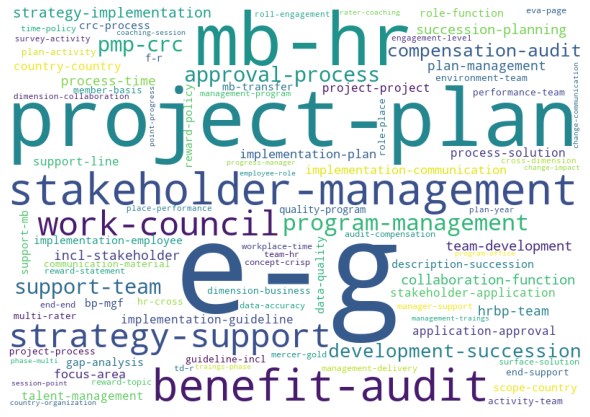

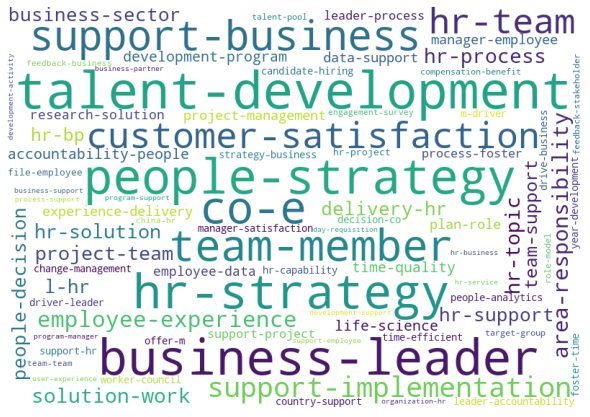

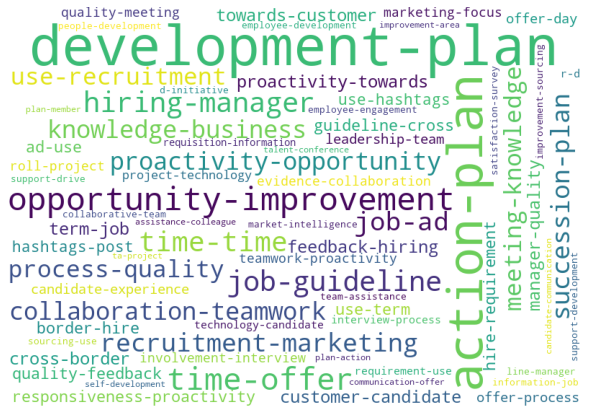

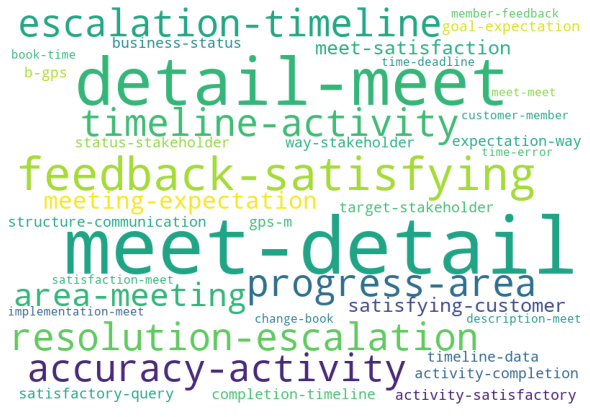

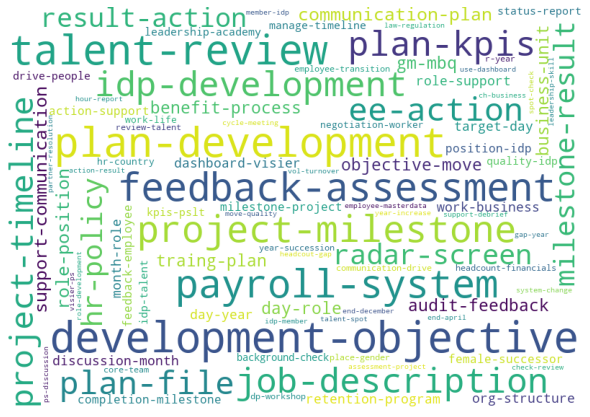

In [31]:
### Top words from LDA
if TopicModelObject.method == 'LDA':
    print("LDA model coherence score is: ", TopicModelObject.get_coherence())

    lda_class_distribution = TopicModelObject.vec['LDA']
    labels = np.argmax(lda_class_distribution, axis=1)

    for k, cluster_word_distribution in TopicModelObject.get_top_words_base(top=200).items():

        cluster_word_distribution_dict = dict()
        for item in cluster_word_distribution:
            cluster_word_distribution_dict[item[0]] = item[1]

        get_wordcloud(dir=TopicModelObject.dir, word_distribution=cluster_word_distribution_dict, topic=k)
        

# Get top words from autoencoder (LDA + Embeddings) and create word clouds on n grams
else:
    grams = 2
    for ng in range(grams):
        topic_words = []
        print("WordClouds for {} grams".format(str(ng + 1)))
        # get topic words for all clusters
        new_token_lists = []
        for i in range(TopicModelObject.k):
            k_sentences = np.array(sentences)[sentence_label_dict[i]]
            ngram_token_with_frequency, token_list = generate_n_gram(k_sentences, n=ng + 1, separator='-',
                                                                     keep_stopwords=False, stem=True,
                                                                     keep_nouns_only=True)

            new_token_lists += token_list
            topic_words.append(ngram_token_with_frequency)

        # remove simliar words from clusters
        print("Coherence Score before cleaning of redundant words")
        print(TopicModelObject.get_coherence(get_main_topics(topic_words), new_token_lists))

        topic_words = clean_topics_from_clusters(topics=topic_words, delete = False)

        print("Coherence Score after cleaning of redundant words")
        print(TopicModelObject.get_coherence(get_main_topics(topic_words), new_token_lists))

        # generate wordclouds
        for i in range(TopicModelObject.k):
            get_wordcloud(topic=i, word_count_dict=topic_words[i], dir=TopicModelObject.dir)

In [20]:
TopicModelObject.dir

'output/EMBEDDING/EMBEDDING_k_5_bert-sent_2020_10_26_12_13_55/'

#### 4.1.2 WordCloud using top words from embedding model attention.
Use only when the following embeddings have been used [xlnet, bert, xlm, electra, albert]

In [ ]:
import os
topic_words = []
layer = 1
head = None
# get topic words for all clusters
new_token_lists = []
for i in range(TopicModelObject.k):

    token_with_frequency, token_list = TopicModelObject.get_top_words_using_attention (
        sentence_label_dict=sentence_label_dict, cluster_id = i, layer = layer, head = head, top = 15)
    
    new_token_lists += token_list
    topic_words.append(token_with_frequency)

# remove simliar words from clusters
print("Coherence Score before cleaning of redundant words")
print(TopicModelObject.get_coherence(get_main_topics(topic_words), new_token_lists))

#topic_words = clean_topics_from_clusters(topics=topic_words)

print("Coherence Score after cleaning of redundant words")
print(TopicModelObject.get_coherence(get_main_topics(topic_words), new_token_lists))

sav_dir = TopicModelObject.dir + '/layer_{}head_{}/'.format(layer,head)
if not os.path.exists(sav_dir):
    os.makedirs(sav_dir)
# generate wordclouds
for i in range(TopicModelObject.k):
    get_wordcloud(topic=i, word_count_dict=topic_words[i], dir=sav_dir)

#### 4.1.3 Get Wordcloud using top words from TF-IDF

Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!


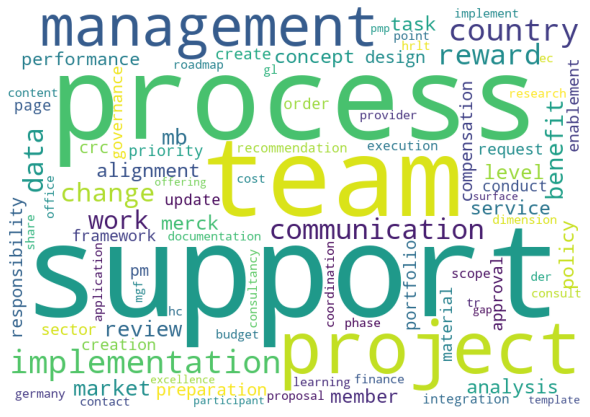

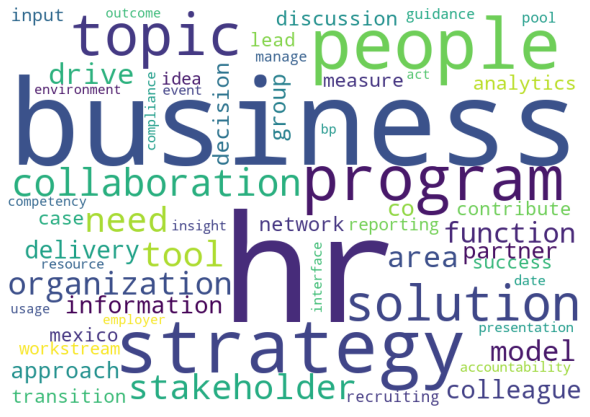

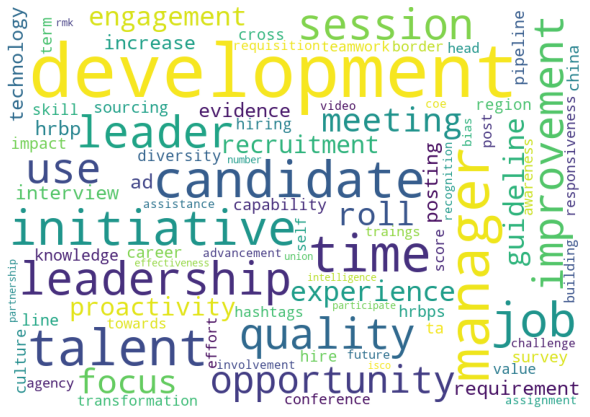

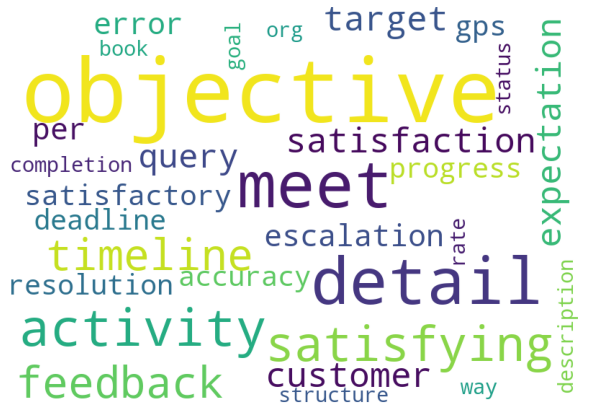

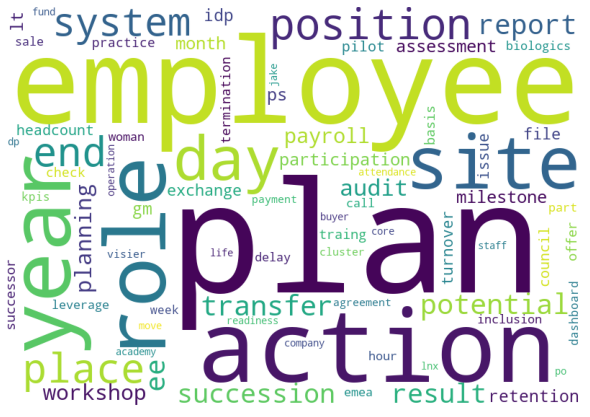

In [21]:
topic_words = TopicModelObject.get_top_words_tfidf(sentence_token=token_lists, sentences=sentences,
                                           sentence_label_dict=sentence_label_dict, top=200)
# remove reduntant words from clusters
topic_words = clean_topics_from_clusters(topics=topic_words, delete = False)


# generate wordclouds
for i in range(TopicModelObject.k):
    get_wordcloud(topic=i, word_count_dict=topic_words[i], dir=TopicModelObject.dir)

## 4.2 Visualization: Scatter plot

Visualize the feature vectors of each employee in a 2d/3d space using plotly

In [22]:
import plotly.graph_objects as go
from sklearn import preprocessing

In [23]:
from collections import Counter
#main topics for each cluster
cluster_titles = []
topic_words = []

#first get the clean topic words
for i in range(TopicModelObject.k):
    k_sentences = np.array(sentences)[sentence_label_dict[i]]
    ngram_token_with_frequency, _ = generate_n_gram(k_sentences, n=1, separator='-',
                                                                     keep_stopwords=False, stem=True,
                                                                     keep_nouns_only=True)
    topic_words.append(ngram_token_with_frequency)

# remove same words from clusters

topic_words = clean_topics_from_clusters(topics=topic_words, delete = False)
    
#pick the top ones and create label string out of it
    
for i in range(TopicModelObject.k):
    
    cluster_token = Counter(topic_words[i])    
    cluster_title = ', '.join([key for key, value in cluster_token.most_common(10)])
    cluster_titles.append(cluster_title)
    
cluster_titles

['management, country, benefit, mb, market, create, policy, concept, implement, audit',
 'support, hr, team, business, project, process, employee, manager, strategy, people',
 'development, plan, time, feedback, job, action, candidate, use, leader, site',
 'detail, satisfying, satisfactory, gps',
 'gm, retention, file, kpis, turnover, month, headcount, hour, buyer, eur']

In [24]:
np_sentences = np.array(sentences)

In [25]:
fig = go.Figure()


for i, cl in enumerate(range(k)):
    
    cluster_df = averaged_employee_features[averaged_employee_features.cluster==cl]
    #plot all the employees belonging to a cluster using a new trace. 
    features = np.stack(cluster_df['feature_vector_2d'].to_numpy())

    employee_titles = []
    # constructing hover text (all objectives belonging to that employee) 
    for emp in cluster_df.index.values:
        
        emp_index = employee_objective_indices[emp]
        employee_title = np_sentences[emp_index]
    
        employee_titles.append(emp + ': ' + employee_title[0:100])
        
    fig.add_trace(go.Scattergl(
      x=features[:, 0],
      y=features[:, 1],
      mode='markers',
      showlegend=True,
      text = employee_titles,
      marker=dict(size=8, color=i),
      name="cluster_"+str(cl+1) +": " + cluster_titles[cl]
      ))



fig.update_layout(title='Distribution of employees over clusters in 2d space', legend=dict(
        x=0.6,
        y=1.4,
        traceorder='normal',
        font=dict(
            size=10)))
fig.show()

path = TopicModelObject.dir + '2D_clusters.jpeg'
fig.write_image(path)


In [26]:
fig = go.Figure()


for i, cl in enumerate(range(k)):
    cluster_df = averaged_employee_features[averaged_employee_features.cluster==cl]

    #plot all the employees belonging to a cluster using a new trace. 
    features = np.stack(cluster_df['feature_vector_2d'].to_numpy())
    
    #normalize the features between 0 and 1
    features_normed = preprocessing.normalize(features)
    # Normalize the features between 0 and 1 before visualization
    min_ = features.min(axis=0)
    max_ = features.max(axis=0)
    features_normed = (features - min_) / (max_ - min_)
    
    employee_titles = []
    # constructing hover text (all objectives belonging to that employee) 
    for emp in cluster_df.index.values:
        
        emp_index = employee_objective_indices[emp]
        employee_title = np_sentences[emp_index]
    
        employee_titles.append(emp + ': ' + employee_title[0:100])


    fig.add_trace(go.Scattergl(
      x=features_normed[:, 0],
      y=features_normed[:, 1],
      mode='markers',
      showlegend=True,
      text = employee_titles,
      marker=dict(size=8, color=i),
      name="cluster_"+str(cl+1) +": " + cluster_titles[cl]
    ))



fig.update_layout(title='Distribution of employees over clusters in 2d space - Normalized', legend=dict(
        x=0.6,
        y=1.4,
        traceorder='normal',
        font=dict(
            size=10)))
fig.show()
path = TopicModelObject.dir + '2D_clusters_norm.jpeg'
fig.write_image(path)

In [27]:
fig = go.Figure()
for i , cl in enumerate(range(k)):
    
    cluster_df = averaged_employee_features[averaged_employee_features.cluster==cl]

    #plot all the employees belonging to a cluster using a new trace. 
    features = np.stack(cluster_df['feature_vector_3d'].to_numpy())
    
    employee_titles = []
    # constructing hover text (all objectives belonging to that employee) 
    for emp in cluster_df.index.values:
        
        emp_index = employee_objective_indices[emp]
        employee_title = np_sentences[emp_index]
    
        employee_titles.append(emp + ': ' + employee_title[0:100])


    fig.add_trace(go.Scatter3d(
      x=features[:, 0],
      y=features[:, 1],
      z=features[:, 2],
      mode='markers',
      showlegend=True,
      text = employee_titles,
      marker=dict(size=3, color=i),
      name="cluster_"+str(cl+1) +": " + cluster_titles[cl]
    ))

fig.update_layout(title='Distribution of employees over clusters in 3d Space', legend=dict(
        x=0.6,
        y=1.4,
        traceorder='normal',
        font=dict(
            size=10)))
fig.show()
path = TopicModelObject.dir + '3D_clusters.jpeg'
fig.write_image(path)

In [28]:
fig = go.Figure()

for i, cl in enumerate(range(k)):
    cluster_df = averaged_employee_features[averaged_employee_features.cluster==cl]

    #plot all the employees belonging to a cluster using a new trace. 
    features = np.stack(cluster_df['feature_vector_3d'].to_numpy())
    
    #normalize the features between 0 and 1
    
    
    min_ = features.min(axis=0)
    max_ = features.max(axis=0)

    features_normed = (features - min_) / (max_ - min_)
    #features_normed = preprocessing.normalize(features)

    
    employee_titles = []
    # constructing hover text (all objectives belonging to that employee) 
    for emp in cluster_df.index.values:
        
        emp_index = employee_objective_indices[emp]
        employee_title = np_sentences[emp_index]
    
        employee_titles.append(emp + ': ' + employee_title[0:100])


    fig.add_trace(go.Scatter3d(
      x=features_normed[:, 0],
      y=features_normed[:, 1],
      z=features_normed[:, 2],
      mode='markers',
      showlegend=True,
      text = employee_titles,
      marker=dict(size=3, color=i),
      name="cluster_"+str(cl+1) +": " + cluster_titles[cl]
    ))

fig.update_layout(title='Distribution of employees over clusters in 3d Space - Normalized', legend=dict(
        x=0.6,
        y=1.4,
        traceorder='normal',
        font=dict(
            size=10)))
fig.show()
path = TopicModelObject.dir + '3d_clusters_norm1.jpeg'
fig.write_image(path)

### 4.3 pyLDAvis
This visualization only works on LDA results

In [37]:
import pyLDAvis
from pyLDAvis import gensim as gs

[nltk_data] Downloading package wordnet to /home/anum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
id2word = corpora.Dictionary(token_lists)
corpus = [id2word.doc2bow(text) for text in token_lists]

NameError: name 'corpora' is not defined

In [39]:
pyLDAvis.enable_notebook()
vis = gs.prepare(TopicModelObject.ldamodel, corpus, id2word)
vis

AttributeError: 'Topic_Model' object has no attribute 'ldamodel'